In [137]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")

## GPIO Library Functions

In [138]:
%%microblaze base.PMODA

#include "gpio.h"
#include "pyprintf.h"
#define GPIO0 0
#define GPIO1 1
#define GPIO2 2

//Function to turn on/off a selected pin of PMODA
void write_gpio(unsigned int pin, unsigned int val){
    if (val > 1){
        pyprintf("pin value must be 0 or 1");
    }
    gpio pin_out = gpio_open(pin);
    gpio_set_direction(pin_out, GPIO_OUT);
    gpio_write(pin_out, val);
}

//Function to read the value of a selected pin of PMODA
unsigned int read_gpio(unsigned int pin){
    gpio pin_in = gpio_open(pin);
    gpio_set_direction(pin_in, GPIO_IN);
    int a = gpio_read(pin_in);
    pyprintf("pin %d --- val is %d\n", pin, a);
    return a;
}

void reset_all_gpios()
{
    pyprintf("reset PMOD \n");
    for(int pin=0; pin < 6; pin++) 
    {
        write_gpio(pin, 0);
    }
}

void write_led(unsigned int val){
    if (val > 9){
        pyprintf("pin value must be between 0 to 9\n");
    }
    
    write_gpio(GPIO0, val & 0x1);
    //pyprintf("val %d --- pin val is %d\n", val, val & 0x01);
    
    write_gpio(GPIO1, (val & 2) >> 1);
    //pyprintf("pin2 value %d\n", (val & 2) >> 1);
    
    write_gpio(GPIO2, (val & 4) >> 2);
    //pyprintf("pin3 value %d\n", (val & 4) >> 2);

}

In [139]:
#Reset all gpios
reset_all_gpios()

## Python3 cell that emulates a PWM

In [135]:
import time

def emulatePwm(frequency, dutycycle, color):
    period = 1 / frequency
    newDutyCycle = dutycycle / 100
    delay = period * newDutyCycle
    
    count = frequency
    
    if dutycycle == 100:
        write_led(color)
        time.sleep(period);
    
    elif dutycycle == 0:
        write_led(0)
        time.sleep(period);
    
    else:
        while count:
            write_led(color)
            time.sleep(delay);
            
            write_led(0)
            time.sleep(period - delay);
    
            count -= 1

## Achieve the visually perceived 100%, 75%, 50% and 25% of full LED brightness by adjusting the duty cycle

In [27]:
#Set -ve pin to ground (0)
reset_all_gpios()

emulatePwm(50, 100, 4)
emulatePwm(50, 75, 4)
emulatePwm(50, 50, 4)
emulatePwm(50, 25, 4)
emulatePwm(50, 0, 4)


# Approx. relationship of perceived LED brightness % versus duty cycle %

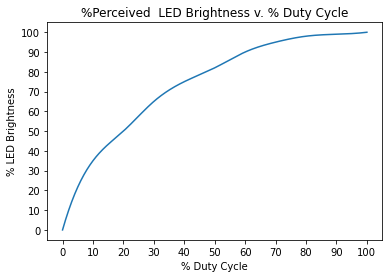

In [6]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
 
# Dataset
x = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
y = np.array([0, 35, 50, 65, 75, 82, 90, 95, 98, 99, 100])
 
X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

plt.plot(X_,Y_)

plt.xlabel('% Duty Cycle')
plt.ylabel('% LED Brightness')
plt.title('%Perceived  LED Brightness v. % Duty Cycle')

plt.xticks(np.arange(0,110,10))
plt.yticks(np.arange(0,110,10))

plt.show()

# Concurrency, Buttons, and PWM

In [140]:
btns = base.btns_gpio

import asyncio

cond = True
flash = 4 #RED

async def flash_leds():
    global cond, flash
    while cond:
        if flash > 0:
            emulatePwm(40, 25, flash)
            await asyncio.sleep(1)
            reset_all_gpios()
            await asyncio.sleep(1)
        else:
            reset_all_gpios()
            cond = False
            await asyncio.sleep(0.05)
            
async def get_btns(_loop):
    global cond, start, flash
    while cond:
        await asyncio.sleep(0.01)
        if btns.read() == 1:
            flash = 4
        if btns.read() == 2:
            flash = 2
        if btns.read() == 4:
            flash = 1
        if btns.read() == 8:
            flash = 0
            _loop.stop()
            

#write_gpio(3,0)
reset_all_gpios()
loop = asyncio.new_event_loop()
loop.create_task(flash_leds())
loop.create_task(get_btns(loop))
loop.run_forever()
loop.close()        